In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable

# a class for fancy 3d arrow plotting
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
def CreateTriangleLocations(n):
    u = np.linspace(-1,1,n)
    x,y = np.meshgrid(u,u)
    x = x.flatten(); y = y.flatten()
    ind = np.where(x<(-y)+2/n/10)
    return x[ind],y[ind]

def CreatePrismLocations(n):
    zp = np.linspace(-1,1,n)
    xp,yp = CreateTriangleLocations(n)
    x = xp[:,np.newaxis] * np.ones(zp.size)
    y = yp[:,np.newaxis] * np.ones(zp.size)
    z = np.ones(xp.shape)[:,np.newaxis] * zp
    return x.flatten(order='f'),y.flatten(order='f'),z.flatten(order='f')

As a prime basis, we will start with the hexahedral basis from (Wheeler, Xue & Yotov, 2012) which has a dimension of 24.

In [2]:
def WheelerXueYotov(x,y,z):
    V = np.zeros((3,x.size,24))
    O = np.zeros(x.size)
    for d in range(3):
        V[d,:,4*d+0] = np.ones(x.size)
        V[d,:,4*d+1] = x
        V[d,:,4*d+2] = y
        V[d,:,4*d+3] = z
    V[...,12] = [     x*z,     -y*z,        O] # curl(0       ,0       ,x*y*z   )
    V[...,13] = [   2*x*y,    -y**2,        O] # curl(0       ,0       ,x*y**2  )
    V[...,14] = [       O,   -2*x*z,        O] # curl(0       ,0       ,x**2*z  )
    V[...,15] = [  x**2*z, -2*x*y*z,        O] # curl(0       ,0       ,x**2*y*z)
    V[...,16] = [       O,      x*y,     -x*z] # curl(x*y*z   ,0       ,0       )
    V[...,17] = [       O,    2*y*z,    -z**2] # curl(y*z**2  ,0       ,0       )
    V[...,18] = [       O,        O,   -2*x*y] # curl(x*y**2  ,0       ,0       )
    V[...,19] = [       O,   x*y**2, -2*x*y*z] # curl(x*y**2*z,0       ,0       )
    V[...,20] = [    -x*y,        O,      y*z] # curl(0       ,x*y*z   ,0       )
    V[...,21] = [   -x**2,        O,    2*x*z] # curl(0       ,x**2*z  ,0       )
    V[...,22] = [  -2*y*z,        O,        O] # curl(0       ,y*z**2  ,0       )
    V[...,23] = [-2*x*y*z,        O,   y*z**2] # curl(0       ,x*y*z**2,0       ) 
    return V

We could keep the space of dimension 24, and introduce two interior nodes in order to form a prismatic basis as in (Egger & Radu, 2018).

In [3]:
xn = np.zeros(24); yn = np.zeros(24); zn = np.zeros(24); n = np.zeros((24,3)); s = 1/np.sqrt(2)

# face x = -1
xn[0],yn[0],zn[0] = -1,-1,-1
xn[1],yn[1],zn[1] = -1,+1,-1
xn[2],yn[2],zn[2] = -1,+1,+1
xn[3],yn[3],zn[3] = -1,-1,+1
n[:4,0] = -1

# face y = -1
xn[4],yn[4],zn[4] = -1,-1,-1
xn[5],yn[5],zn[5] = +1,-1,-1
xn[6],yn[6],zn[6] = +1,-1,+1
xn[7],yn[7],zn[7] = -1,-1,+1
n[4:8,1] = -1

# face y = -x
xn[ 8],yn[ 8],zn[ 8] = +1,-1,-1
xn[ 9],yn[ 9],zn[ 9] = -1,+1,-1
xn[10],yn[10],zn[10] = -1,+1,+1
xn[11],yn[11],zn[11] = +1,-1,+1
n[8:12,:2] = s

# face z = -1
xn[12],yn[12],zn[12] = -1,-1,-1
xn[13],yn[13],zn[13] = +1,-1,-1
xn[14],yn[14],zn[14] = -1,+1,-1
n[12:15,2] = -1

# face z = +1
xn[15],yn[15],zn[15] = -1,-1,+1
xn[16],yn[16],zn[16] = +1,-1,+1
xn[17],yn[17],zn[17] = -1,+1,+1
n[15:18,2] = 1 

# lower interior node
xn[18],yn[18],zn[18] = -1/3,-1/3,-1/3
xn[19],yn[19],zn[19] = -1/3,-1/3,-1/3
xn[20],yn[20],zn[20] = -1/3,-1/3,-1/3
n[18,0] = 1; n[19,1] = 1; n[20,2] = 1

# upper interior node
xn[21],yn[21],zn[21] = -1/3,-1/3,+1/3
xn[22],yn[22],zn[22] = -1/3,-1/3,+1/3
xn[23],yn[23],zn[23] = -1/3,-1/3,+1/3
n[21,0] = 1; n[22,1] = 1; n[23,2] = 1

To help visualize where the nodal degrees of freedom would be (and to check that I have written the conditions correctly) we plot the reference prism as before where the DOFs related to the same face / interior vertex are colored consistently.

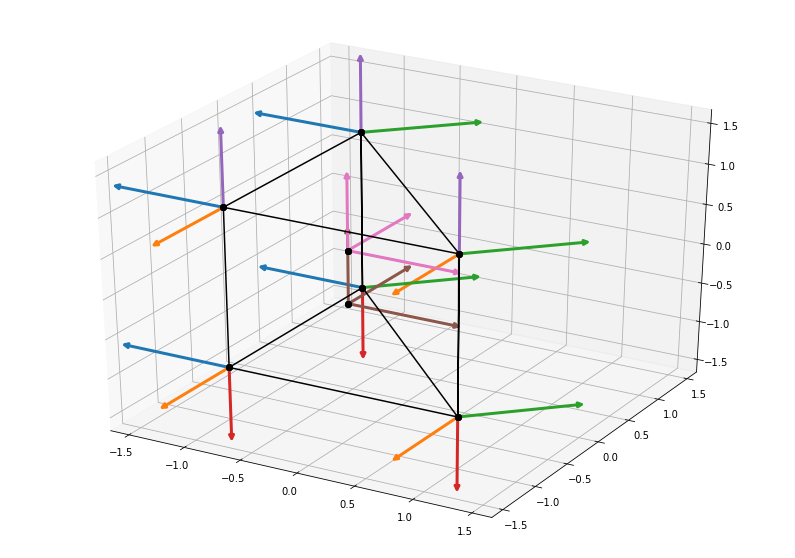

In [4]:
xv,yv,zv = CreatePrismLocations(2)
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111,projection='3d')
cell = [0,1,2,0,3,4,1,4,5,2,5,3]
plt.plot(xv[cell],yv[cell],zv[cell],'-k')
plt.plot(xn,yn,zn,'ok')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(3):
    clr = colors[i]
    for j in range(4):
        k = i*4+j
        ax.add_artist(Arrow3D([xn[k],xn[k]+n[k,0]],
                              [yn[k],yn[k]+n[k,1]],
                              [zn[k],zn[k]+n[k,2]], 
                              mutation_scale=10,lw=3,arrowstyle="-|>",color=clr))
for i in range(4):
    clr = colors[3+i]
    for j in range(3):
        k = 12+i*3+j
        ax.add_artist(Arrow3D([xn[k],xn[k]+n[k,0]],
                              [yn[k],yn[k]+n[k,1]],
                              [zn[k],zn[k]+n[k,2]], 
                              mutation_scale=10,lw=3,arrowstyle="-|>",color=clr))
L,R = -1.6,1.6; ax.set_xlim(L,R); ax.set_ylim(L,R); ax.set_zlim(L,R)
plt.show()

We then use the generalized Vandermonde matrix to transform the prime basis into a nodel basis. Note that for my choice here, the condition number on the Vandermonde matrix is poor, which will also be reflected in what looks like noise in the basis plots below. I think it is because the conditions on my interior nodes are too similar, leading to nearly identical rows of the matrix.

In [5]:
xp,yp,zp = CreatePrismLocations(31)
P = WheelerXueYotov(xp,yp,zp)
V = np.einsum('dij,id->ij',WheelerXueYotov(xn,yn,zn),n)
N = np.linalg.inv(V).T @ np.swapaxes(P,2,1)
print("cond(V) = %e" % (np.linalg.cond(V)))

cond(V) = 1.116718e+17


As with the Chen and Douglas basis, the 3D vector functions are hard to visualize. I found it helpful to think about what the functions are doing on the faces. Below are a few of them. I have omitted the normal components of the interior functions on the faces, but they should all be zero. You will see that we roughly capture the expected nodal behavior but there is noise, presumably from the poor condition number of the Vandermonde matrix. Notice that the top and bottom faces are not exactly linear, there is a slight bilinear bend.

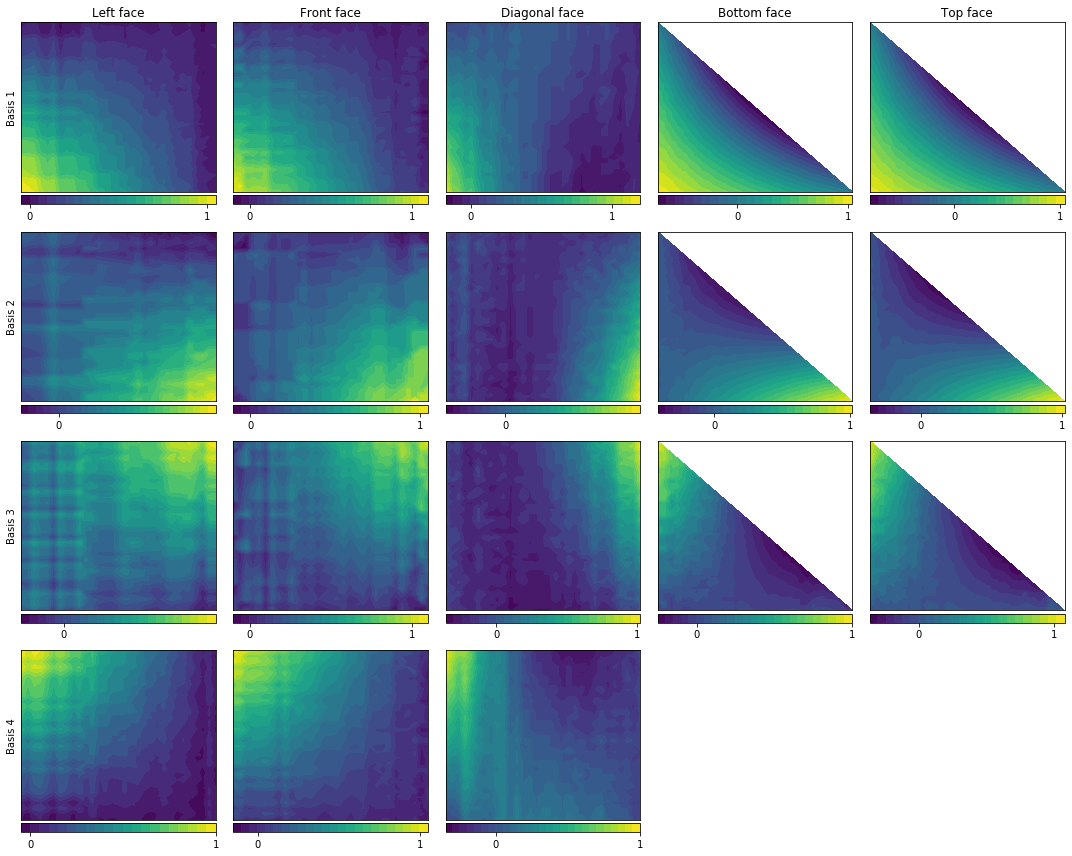

In [6]:
def PlotBasisPlane(condition,x,y,normal,basis,ax):
    ind = np.where(condition)[0]
    T = tri.Triangulation(x[ind],y[ind])
    data = normal @ basis[:,ind]
    p = ax.tricontourf(T,data,25)
    ax.set_xticks([]); ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom',size='5%',pad=0.05)
    plt.colorbar(p,cax=cax,ticks=[0,1],orientation='horizontal')

fig,ax = plt.subplots(nrows=4,ncols=5,tight_layout=True,figsize=(15,12))

PlotBasisPlane(np.abs(xp-(-1))<1e-3,yp,zp,n[0],N[:,0,:],ax[0,0])
PlotBasisPlane(np.abs(xp-(-1))<1e-3,yp,zp,n[1],N[:,1,:],ax[1,0])
PlotBasisPlane(np.abs(xp-(-1))<1e-3,yp,zp,n[2],N[:,2,:],ax[2,0])
PlotBasisPlane(np.abs(xp-(-1))<1e-3,yp,zp,n[3],N[:,3,:],ax[3,0])

PlotBasisPlane(np.abs(yp-(-1))<1e-3,xp,zp,n[4],N[:,4,:],ax[0,1])
PlotBasisPlane(np.abs(yp-(-1))<1e-3,xp,zp,n[5],N[:,5,:],ax[1,1])
PlotBasisPlane(np.abs(yp-(-1))<1e-3,xp,zp,n[6],N[:,6,:],ax[2,1])
PlotBasisPlane(np.abs(yp-(-1))<1e-3,xp,zp,n[7],N[:,7,:],ax[3,1])

PlotBasisPlane(np.abs(xp+yp)<1e-3,yp,zp,n[ 8],N[:, 8,:],ax[0,2])
PlotBasisPlane(np.abs(xp+yp)<1e-3,yp,zp,n[ 9],N[:, 9,:],ax[1,2])
PlotBasisPlane(np.abs(xp+yp)<1e-3,yp,zp,n[10],N[:,10,:],ax[2,2])
PlotBasisPlane(np.abs(xp+yp)<1e-3,yp,zp,n[11],N[:,11,:],ax[3,2])

PlotBasisPlane(np.abs(zp-(-1))<1e-3,xp,yp,n[12],N[:,12,:],ax[0,3])
PlotBasisPlane(np.abs(zp-(-1))<1e-3,xp,yp,n[13],N[:,13,:],ax[1,3])
PlotBasisPlane(np.abs(zp-(-1))<1e-3,xp,yp,n[14],N[:,14,:],ax[2,3])

PlotBasisPlane(np.abs(zp-(+1))<1e-3,xp,yp,n[15],N[:,15,:],ax[0,4])
PlotBasisPlane(np.abs(zp-(+1))<1e-3,xp,yp,n[16],N[:,16,:],ax[1,4])
PlotBasisPlane(np.abs(zp-(+1))<1e-3,xp,yp,n[17],N[:,17,:],ax[2,4])

ax[3,3].axis('off')
ax[3,4].axis('off')
ax[0,0].set_title("Left face")
ax[0,1].set_title("Front face")
ax[0,2].set_title("Diagonal face")
ax[0,3].set_title("Bottom face")
ax[0,4].set_title("Top face")
ax[0,0].set_ylabel("Basis 1")
ax[1,0].set_ylabel("Basis 2")
ax[2,0].set_ylabel("Basis 3")
ax[3,0].set_ylabel("Basis 4")
plt.show()